In [1]:
HIGH_RISK = set(
    ("chest pain",
    "difficulty breathing",
    "unconscious",
    "seizure",
    "heavy bleeding",
    "suicidal thoughts",
    "stroke symptoms")
)

NEGATIONS = {"no", "not", "dont", "don't", "without"}
emergency_symptoms = {'high' , 'severe', 'sudden', 'unbearable', 'worsening', 'persistent'}
def check_risk(user_query: str) -> dict:
    user_query = user_query.lower()

    for symptom in HIGH_RISK:
        if symptom in user_query:
            
            words = user_query.split()
            symptom_words = symptom.split() #Check for simple negation

            for i in range(len(words) - len(symptom_words) + 1):
                if words[i:i+len(symptom_words)] == symptom_words:
                    
                    window = words[max(0, i-2):i] ## check previous 2 words for negation
                    if any(neg in window for neg in NEGATIONS):
                        continue

                    intensity_window = (
                        words[max(0, i-3):i] +
                        words[i+len(symptom_words): i+len(symptom_words)+3]
                    )
                    if any(emergency in window for emergency in intensity_window):
                        return {
                        "risk_level": "moderate - high",
                        "advice": "Seek immediate medical attention or call emergency services."
                        }
                    return {
                        "risk_level": "high",
                        "advice": "Seek immediate medical attention or call emergency services."
                    }

    return {
        "risk_level": "low",
        "advice": "Monitor your symptoms and consult a healthcare professional if they worsen."
    }


user_query = "I have no chest pain but high difficulty breathing."
result = check_risk(user_query)




In [2]:
result

{'risk_level': 'low',
 'advice': 'Monitor your symptoms and consult a healthcare professional if they worsen.'}

In [3]:
import mysql.connector

def get_connection():
    return mysql.connector.connect(
        host="127.0.0.1",
        user="root",
        password="Msaa@1234",
        database="DoctorDB",
        port=3306
    )
    

In [4]:
import mysql.connector

try:
    conn = mysql.connector.connect(
        host="127.0.0.1",
        user="root",
        password="Msaa@1234",
        database="DoctorDB",
        port=3306
    )
    print("Database is running!")
    conn.close()
except:
    print("Database is NOT running.")


Database is running!


In [5]:
!pip install mysql-connector-python


^C


In [6]:
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import StateGraph
from dotenv import load_dotenv
import os
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("groq_api_key")

model = ChatGroq(model_name="meta-llama/llama-4-scout-17b-16e-instruct")

prompt = ChatPromptTemplate(
    input_variables=["symptoms"],
    messages=[
        SystemMessage(content="You are a helpful assistant."),
        HumanMessage(content="{symptoms}")
    ]
)

graph = StateGraph()

graph.add_node("llm", model)





# while True:
#     print("\n--- AI Medical Agent ---")
#     user_input = input("You: ")
#     if user_input.lower() == "exit" or user_input.lower() == "quit":
#         break
    
#     response = chain.invoke({"symptoms": user_input})
#     print("Agent: ", response)
    



TypeError: StateGraph.__init__() missing 1 required positional argument: 'state_schema'

In [ ]:
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import StateGraph
from dotenv import load_dotenv
import os
import asyncio
import operator
from langchain_core.messages import AnyMessage , AIMessage , HumanMessage
from typing_extensions import Annotated , TypedDict
from mcp_use import MCPAgent, MCPClient

load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("groq_api_key")

model = ChatGroq(model_name="meta-llama/llama-4-scout-17b-16e-instruct")

prompt = ChatPromptTemplate(
    input_variables=["symptoms"],
    messages=[
        SystemMessage(content="You are a helpful assistant."),
        HumanMessage(content="{symptoms}")
    ]
)
class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage] , operator.add]

async def mcp_call(state: GraphState) -> GraphState:
    """Calls the MCP server with the current graph state and updates the graph state with the response"""
    
    client = "{config_mcp.json}"

    client = MCPClient.from_dict(client)

    mcp_agent = MCPAgent(llm_call , client = client)
    result = await mcp_agent.run(state)
    
    return result



def llm_call(state:GraphState) -> GraphState:
    """Calls the LLM with the current graph state and updates the graph state with the response"""
    
    response = model.invoke(state["messages"])
    state["messages"].append(response)
    return state

graph = StateGraph(GraphState)

model = model.bind_tools([mcp_call])
graph.add_node("llm_call", llm_call)
graph.add_node("mcp_call" , mcp_call)


graph.set_entry_point("mcp_call")
graph.add_edge("mcp_call" , "llm_call")
graph.set_finish_point("llm_call")



# while True:
#     print("\n--- AI Medical Agent ---")
#     user_input = input("You: ")
#     if user_input.lower() == "exit" or user_input.lower() == "quit":
#         break
    
#     response = chain.invoke({"symptoms": user_input})
#     print("Agent: ", response)
    



2026-02-13 23:34:27,086 - mcp_use.telemetry.telemetry - INFO - Anonymized telemetry enabled. Set MCP_USE_ANONYMIZED_TELEMETRY=false to disable.


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: C:\Python312\python.exe -m pip install --upgrade pip


In [ ]:
app = graph.compile()

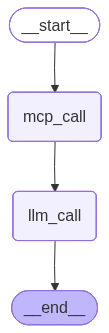

In [ ]:
app

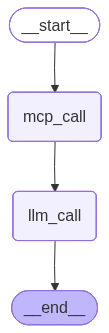

In [57]:
from IPython.display import Image , display
display(Image(app.get_graph().draw_mermaid_png()))

In [4]:
async def mcp_call(state: GraphState) -> GraphState:
    """Calls the MCP server with the current graph state and updates the graph state with the response"""
    
    with open("config_mcp.json", "r") as f:
        config = json.load(f)
  
    client = MCPClient.from_dict(config)

    mcp_agent = MCPAgent(model, client=client)
    
    query = state["messages"][-1].content
    
    response_content = await mcp_agent.run(query)
    
    
    return {"messages": [AIMessage(content=str(response_content))]}

In [5]:
res = mcp_call({"messages": [HumanMessage(content="high fever")]})

In [10]:
print(type(res))

<class 'coroutine'>


In [9]:
dir(res)

['__await__',
 '__class__',
 '__del__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__name__',
 '__ne__',
 '__new__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'close',
 'cr_await',
 'cr_code',
 'cr_frame',
 'cr_origin',
 'cr_running',
 'cr_suspended',
 'send',
 'throw']

In [14]:
symptom = "chest pain"

In [16]:
print(symptom.split())

['chest', 'pain']


In [17]:
"".join(symptom.split())

'chestpain'

In [32]:
from langgraph.graph import MessagesState
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import StateGraph, END, MessagesState
from dotenv import load_dotenv
import os
import asyncio
import operator
import json
from langchain_core.messages import AnyMessage, AIMessage
from typing_extensions import Annotated, TypedDict
from mcp_use import MCPAgent, MCPClient
from langgraph.prebuilt import ToolNode,tools_condition

load_dotenv()

# Ensure API key is set
if not os.environ.get("GROQ_API_KEY"):
    os.environ["GROQ_API_KEY"] = os.getenv("groq_api_key")

model = ChatGroq(model_name="meta-llama/llama-4-scout-17b-16e-instruct") # Updated model name to a known valid one or kept user's if sure

class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

def func_1(state : MessagesState):
    pass


async def mcp_call(state: GraphState) -> GraphState:
    """Calls the MCP server with the current graph state and updates the graph state with the response"""
    
    with open("config_mcp.json", "r") as f:
        config = json.load(f)
  
    client = MCPClient.from_dict(config)

    mcp_agent = MCPAgent(model, client=client)
    
    query = state["messages"][-1].content
    
    
    response_content = await mcp_agent.run(query)
    
    return {"messages": [AIMessage(content=str(response_content))]}


def llm_call(state:GraphState) -> GraphState:
    """Calls the LLM with the current graph state and updates the graph state with the response"""
    
    response = model.invoke(state["messages"])
    state["messages"].append(response)
    return state

mcp = ToolNode([mcp_call])
graph = StateGraph(GraphState)

graph.add_node("llm_call", llm_call)
graph.add_node("tools" , mcp)

graph.set_entry_point("llm_call")
graph.add_conditional_edges(
    "llm_call",
    tools_condition,
    
)
graph.add_edge("tools" , "llm_call")
graph.set_finish_point("llm_call") 

app = graph.compile()

# def get_response(query: str) -> str:
#     """Interface for app.py to get a response from the agent."""
#     initial_state = {"messages": [HumanMessage(content=query)]}
#     # Run the graph (asyncio.run might be needed if calling from sync code, 
#     # but langgraph compile() returns a runnable that handles async often, 
#     # however mcp_call is async. Let's try invoke first, if it fails we might need async handling)
    
#     # specific handling for async node in sync context if needed
#     try:
#         # For simplicity in this environment, we'll try standard invoke. 
#         # If mcp_call is async, we might need ayncio.run on app.invoke if app is compiled as async
#         # But langgraph's compile usually returns a sync-compatible invoker if nodes are mixed? 
#         # Actually, if nodes are async, invoke needs to be awaited or we use asyncio.run
        
#         loop = asyncio.new_event_loop()
#         asyncio.set_event_loop(loop)
#         result = loop.run_until_complete(app.ainvoke(initial_state))
#         loop.close()
        
#         # Extract last message content
#         return result["messages"][-1].content
#     except Exception as e:
#         return f"Error in agent: {e}"

# if __name__ == "__main__":
#     while True:
#         print("\n--- AI Medical Agent ---")
#         user_input = input("You: ")
#         if user_input.lower() in ["exit", "quit"]:
#             break
        
#         print("Agent:", get_response(user_input))



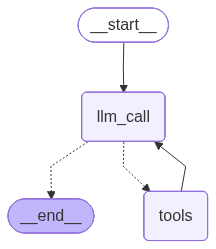

In [33]:
app

In [50]:
response = app.invoke({"messages": [HumanMessage(content="What to do if i ahve high chest pain")]})

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


In [51]:
print(response['messages'][-1].content)

I'm not a doctor, but I can provide general guidance. If you're experiencing high chest pain, it's crucial to take immediate action and seek medical help. Here's what you should do:

1. **Stay calm**: Panicking can worsen the situation. Try to remain calm and focus on getting help.
2. **Call emergency services**: Immediately call your local emergency number (such as 911 in the US) or your country's equivalent. If you're in a remote area with no cell service, try to find a way to get to a hospital or a medical facility as quickly as possible.
3. **Provide your location**: When you call emergency services, provide your location and a brief description of your symptoms.
4. **Follow instructions**: The emergency operator may provide you with guidance on what to do while waiting for help to arrive. Follow their instructions carefully.

If you're experiencing severe chest pain, don't try to drive yourself to the hospital. Instead, wait for emergency services to arrive.

**While waiting for h

In [49]:
import logging
logging.basicConfig(level=logging.INFO)
# Or specifically for mcp_use if it uses a specific logger
logging.getLogger("mcp_use").setLevel(logging.DEBUG)

In [ ]:
from langgraph.graph import MessagesState
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import StateGraph, END, MessagesState
from dotenv import load_dotenv
import os
import asyncio
import operator
import json
from langchain_core.messages import AnyMessage, AIMessage
from typing_extensions import Annotated, TypedDict
from mcp_use import MCPAgent, MCPClient
from langgraph.prebuilt import ToolNode , tools_condition


load_dotenv()

# Ensure API key is set
if not os.environ.get("GROQ_API_KEY"):
    os.environ["GROQ_API_KEY"] = os.getenv("groq_api_key")

model = ChatGroq(model_name="meta-llama/llama-4-scout-17b-16e-instruct") # Updated model name to a known valid one or kept user's if sure

class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

def llm_call(state:GraphState) -> GraphState:
    """Calls the LLM with the current graph state and updates the graph state with the response"""
    
    response = model.invoke(state["messages"])
    state["messages"].append(response)
    return state

async def mcp_call(state: GraphState) -> GraphState:
    """Calls the MCP server with the current graph state and updates the graph state with the response"""
    
    with open("config_mcp.json", "r") as f:
        config = json.load(f)
  
    client = MCPClient.from_dict(config)

    mcp_agent = MCPAgent(model, client=client)
    
    query = state["messages"][-1].content
    
    
    response_content = await mcp_agent.run(query)
    
    return {"messages": [AIMessage(content=str(response_content))]}




graph = StateGraph(GraphState)
mcp = ToolNode([mcp_call])
graph.add_node("llm_call" , llm_call)
graph.add_node("tools", mcp)
graph.set_entry_point("llm_call")
graph.add_conditional_edges(
    "llm_call",
    tools_condition
)


graph.add_edge("tools" , "llm_call") 

app = graph.compile()

# async def get_response(query: str) -> str:
#     """Interface for app.py to get a response from the agent."""
#     initial_state = {"messages": [HumanMessage(content=query)]}
#     # Run the graph (asyncio.run might be needed if calling from sync code, 
#     # but langgraph compile() returns a runnable that handles async often, 
#     # however mcp_call is async. Let's try invoke first, if it fails we might need async handling)
    
#     # specific handling for async node in sync context if needed
#     try:
#         # For simplicity in this environment, we'll try standard invoke. 
#         # If mcp_call is async, we might need ayncio.run on app.invoke if app is compiled as async
#         # But langgraph's compile usually returns a sync-compatible invoker if nodes are mixed? 
#         # Actually, if nodes are async, invoke needs to be awaited or we use asyncio.run
        
#         result = await app.ainvoke(initial_state)
#         return result["messages"][-1].conten
        
#         # Extract last message content
#         return result["messages"][-1].content
#     except Exception as e:
#         return f"Error in agent: {e}"

# if __name__ == "__main__":
    while True:
        print("\n--- AI Medical Agent ---")
        user_input = input("You: ")
        if user_input.lower() in ["exit", "quit"]:
            break
        
        print("Agent:", get_response(user_input))




--- AI Medical Agent ---


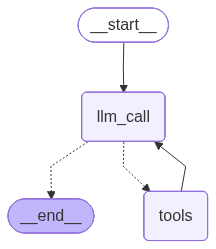

In [73]:
app

tools(tags=None, recurse=True, explode_args=False, func_accepts={'config': ('N/A', <class 'inspect._empty'>), 'runtime': ('N/A', <class 'inspect._empty'>)}, _tools_by_name={'mcp_call': StructuredTool(name='mcp_call', description='Calls the MCP server with the current graph state and updates the graph state with the response', args_schema=<class 'langchain_core.utils.pydantic.mcp_call'>, coroutine=<function mcp_call at 0x00000230220DD3A0>)}, _injected_args={'mcp_call': _InjectedArgs(state={}, store=None, runtime=None)}, _handle_tool_errors=<function _default_handle_tool_errors at 0x000002301FE86480>, _messages_key='messages', _wrap_tool_call=None, _awrap_tool_call=None)

In [ ]:
from langgraph.graph import MessagesState
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import InMemorySaver  
from dotenv import load_dotenv
import os
import asyncio
import operator
import json
from langchain_core.messages import AnyMessage, AIMessage
from typing_extensions import Annotated, TypedDict
from mcp_use import MCPAgent, MCPClient


load_dotenv()

# Ensure API key is set
if not os.environ.get("GROQ_API_KEY"):
    os.environ["GROQ_API_KEY"] = os.getenv("groq_api_key")

model = ChatGroq(model_name="meta-llama/llama-4-scout-17b-16e-instruct") # Updated model name to a known valid one or kept user's if sure

class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

async def mcp_call(state: GraphState) -> GraphState:
    """Calls the MCP server with the current graph state and updates the graph state with the response"""
    
    with open("config_mcp.json", "r") as f:
        config = json.load(f)
  
    client = MCPClient.from_dict(config)

    mcp_agent = MCPAgent(model, client=client)
    
    query = state["messages"][-1].content
    
    
    response_content = await mcp_agent.run(query)
    
    return {"messages": [AIMessage(content=str(response_content))]}




graph = StateGraph(GraphState)
graph.add_node("mcp_call", mcp_call)
checkpointer = InMemorySaver()  

graph.set_entry_point("mcp_call")
graph.set_finish_point("mcp_call") 

app = graph.compile(checkpointer=checkpointer)

# def get_response(query: str) -> str:
#     """Interface for app.py to get a response from the agent."""
#     initial_state = {"messages": [HumanMessage(content=query)]}
   
#     # Run the graph (asyncio.run might be needed if calling from sync code, 
#     # but langgraph compile() returns a runnable that handles async often, 
#     # however mcp_call is async. Let's try invoke first, if it fails we might need async handling)
    
#     # specific handling for async node in sync context if needed
#     try:
#         # For simplicity in this environment, we'll try standard invoke. 
#         # If mcp_call is async, we might need ayncio.run on app.invoke if app is compiled as async
#         # But langgraph's compile usually returns a sync-compatible invoker if nodes are mixed? 
#         # Actually, if nodes are async, invoke needs to be awaited or we use asyncio.run
        
    
        
#         config = {"configurable": {"thread_id": "1"}}
#         loop = asyncio.new_event_loop()
#         asyncio.set_event_loop(loop)
#         result = loop.run_until_complete(app.ainvoke(initial_state, config))
#         loop.close()
        
#         # Extract last message content
#         return result["messages"][-1].content
#     except Exception as e:
#         return f"Error in agent: {e}"

# if __name__ == "__main__":
#     while True:
#         print("\n--- AI Medical Agent ---")
#         user_input = input("You: ")
#         if user_input.lower() in ["exit", "quit"]:
#             break
        
#         print("Agent:", get_response(user_input))

